<a href="https://colab.research.google.com/github/tmallmann/tmallmann/blob/main/people_detection_zone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de pessoas utilizando [YOLO V8](https://ultralytics.com/yolov8) e [SUPERVISION](https://supervision.roboflow.com/).

Tiago Mallmann
04.09.2023

In [1]:
!nvidia-smi


Sun Oct  1 16:10:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Instalação e importação do Ultralytics.

In [2]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
print(ultralytics.checks())


Ultralytics YOLOv8.0.190 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


None


#2. Instalação e importação do Supervision.

In [ ]:
!pip install supervision

display.clear_output()

import supervision as sv
print("Supervision", sv.__version__)


#3. Definição da mídia de entrada.
Faça o upload do seu vídeo para a pasta `/content`.

Link do vídeo utilizado:
https://www.youtube.com/watch?v=ORrrKXGx2SE
Créditos: Muhammed Jamnas.

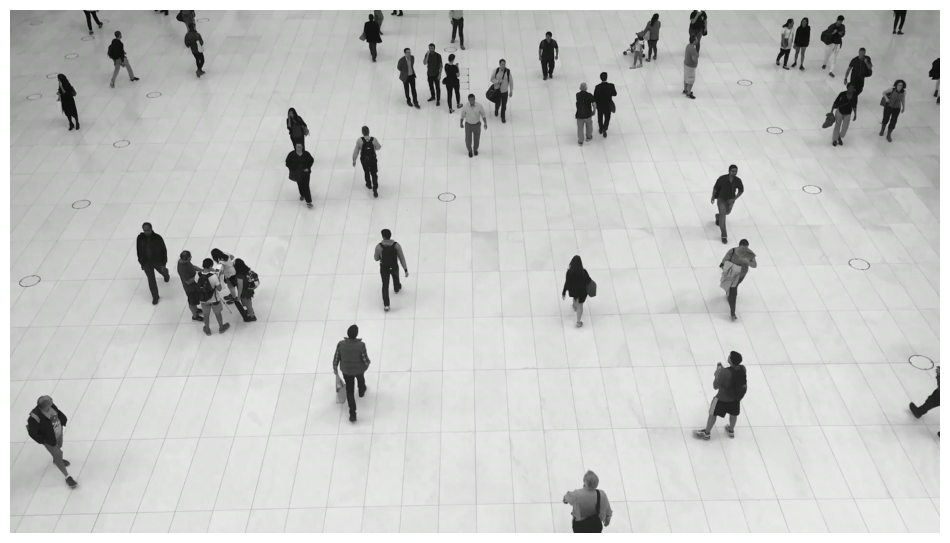

In [ ]:
import os

HOME = os.getcwd()
VIDEO_PATH = f"{HOME}/people.mp4" # Renomear com o nome do seu vídeo

# Para não carregar todo o vídeo na memória, é carregado um frame de cada vez utilizando o 'generator'
generator = sv.get_video_frames_generator(VIDEO_PATH)
frame = next(generator)

# Exibe o primeiro frame do vídeo
sv.plot_image(frame)

#4. Detecção de objetos em frame.


0: 736x1280 43 persons, 7 backpacks, 1 umbrella, 6 handbags, 1 tie, 1 suitcase, 1 tennis racket, 121.6ms
Speed: 7.5ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


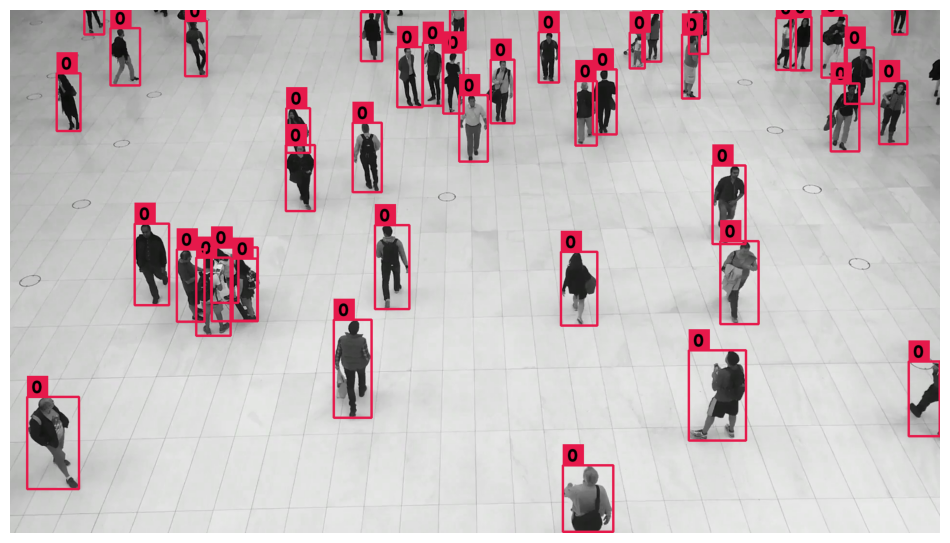

In [ ]:
from ultralytics import YOLO

frame = next(generator)

# Especificação do modelo
model = YOLO('yolov8x.pt')

# Detecção de objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# Detectar apenas pessoas
detections = detections[detections.class_id == 0]

# Criar anotações
box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=3, text_scale=1)
box_annotator.annotate(scene=frame, detections=detections)

sv.plot_image(frame)

Para conferir a lista de objetos detectáveis e seus respectivos `IDs`:

In [ ]:
results.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

#5. Detecção de objetos em vídeo.

É realizada apenas a detecção de pessoas que estiverem dentro de uma zona definida.




In [ ]:
from ultralytics import YOLO
import numpy as np

def process_frame(frame:np.array, _) -> np.array:
  # Detecção de objetos
  results = model(frame, imgsz=1280)[0]
  detections = sv.Detections.from_ultralytics(results)

  # Detectar apenas pessoas
  detections = detections[detections.class_id == 0]

  # Extrair informações do vídeo
  video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

  # Definição da zona de interesse
  polygon = np.array([[675,255], [1080,257], [1132,615], [580,630]])
  zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

  # Disparar um gatilho sempre que houver alguma pessoa dentro da zona
  mask = zone.trigger(detections=detections)
  detections = detections[(detections.class_id == 0) & mask]

  labels = [f"{model.names[class_id]},{confidence:0.2f}" for _, _, confidence, class_id, _ in detections]

  box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=3, text_scale=1)
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=1)

  box_annotator.annotate(scene=frame, detections=detections, labels=labels)
  zone_annotator.annotate(scene=frame)

  return frame

# Resultado
sv.process_video(source_path=VIDEO_PATH, target_path="/content/result.mp4", callback=process_frame)


0: 736x1280 41 persons, 7 backpacks, 4 handbags, 1 suitcase, 198.2ms
Speed: 7.4ms preprocess, 198.2ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 43 persons, 7 backpacks, 1 umbrella, 6 handbags, 1 tie, 1 suitcase, 1 tennis racket, 119.7ms
Speed: 8.9ms preprocess, 119.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 41 persons, 6 backpacks, 1 umbrella, 6 handbags, 1 suitcase, 1 tennis racket, 120.6ms
Speed: 9.5ms preprocess, 120.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 40 persons, 7 backpacks, 1 umbrella, 6 handbags, 1 suitcase, 1 tennis racket, 119.6ms
Speed: 9.2ms preprocess, 119.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 41 persons, 8 backpacks, 1 umbrella, 5 handbags, 1 suitcase, 1 tennis racket, 121.0ms
Speed: 8.5ms preprocess, 121.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 42 persons, 7 backp